In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat # einops 직관적으로 사용할 수 있는 차원관리 package
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Project input to Patches

In [2]:
# input
x = torch.randn(8, 3, 224, 224) # (batch_size, channel, height, width)
print(f'x: {x.shape}')

# b c (h s1) (w s2) # height, width를 각각 patch_size로 나누라는 말
# b (h w) (s1 s2 c) # batch_size는 그대로 두고 h*w로 펼쳐서 1차원으로 만들고(14*14=196) s1*s2*3을 펼쳐서 (16*16*3)이 된다. 
patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', 
                    s1=patch_size, s2=patch_size)
print(f"patches: {patches.shape}")

x: torch.Size([8, 3, 224, 224])
patches: torch.Size([8, 196, 768])


In [3]:
patch_size = 16
in_channels = 3
emb_size = 768 # channel * patch_size * patch_size

projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size), # [-1, 786, 14, 14]
            Rearrange('b e (h) (w) -> b (h w) e') # [-1, 14*14, 786]
)
summary(projection, x.shape[1:], device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.30
Params size (MB): 2.25
Estimated Total Size (MB): 5.12
----------------------------------------------------------------


### Patch Embedding
- patches에 class token & positional embedding을 넣어주기

In [4]:
emb_size = 768
img_size = 224
patch_size = 16

# 이미지를 패치 사이즈로 나누고 flatten
projection_x = projection(x) # [8, 196, 768]
print('Projection X shape: ', projection_x.shape) 

# cls_token과 pos encoding prameter 정의
cls_token = nn.Parameter(torch.randn(1,1,emb_size)) # cls_token은 embedding 갯수만큼 생성
positions = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, emb_size)) # R(N+1 * D) # N+1인 이유는 cls_token 때문에
print('Class Shape: ', cls_token.shape, 'Position Shape: ', positions.shape)

# cls_token을 반복하여 배치사이즈의 크기와 맞춰줌
batch_size = 8
cls_tokens = repeat(cls_token, '() n e -> b n e', b=batch_size) #[8, 1, 768]
print('Repeated Class Shape: ', cls_tokens.shape)

# cls_token과 projected_x를 concatenate
cat_x = torch.cat([cls_tokens, projection_x], dim=1) # [8, 197, 768] # [batch_size, 14*14+1, emb_size]

# position encoding을 더해줌
cat_x += positions # cat_x의 요소에 positions 값을 넣어서 더해줌 # shape에는 변함 없음!
print('output: ', cat_x.shape)

Projection X shape:  torch.Size([8, 196, 768])
Class Shape:  torch.Size([1, 1, 768]) Position Shape:  torch.Size([197, 768])
Repeated Class Shape:  torch.Size([8, 1, 768])
output:  torch.Size([8, 197, 768])


In [5]:
# 어떻게 concatenate되는지 확인해보기
tensor_1 = nn.Parameter(torch.randn(4, 1, 16))
tensor_2 = nn.Parameter(torch.randn(4, 8, 16))
cat_tensor = torch.cat([tensor_1, tensor_2], dim=1)
print('cat shape: ', cat_tensor.shape)

cat shape:  torch.Size([4, 9, 16])


In [6]:
# Class 형태로 만들어주기
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, emb_size:int=768, img_size:int=224) -> None:
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, emb_size))
    
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape # batch_size 선언
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

patch_emb = PatchEmbedding()
summary(patch_emb, (3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 2.30
Params size (MB): 2.25
Estimated Total Size (MB): 5.12
----------------------------------------------------------------


### Multi Head Attention
패치들에 대해서 self attention 적용
1. key, query, value는 모두 같은 값
2. linear layer를 통과하여 self-attention 적용
3. 스케일링
4. value와 연산 후 input과 같은 shape으로 reshape

In [7]:
emb_size = 768
num_heads = 8

# q, k, v 정의하기
keys = nn.Linear(emb_size, emb_size)
queries = nn.Linear(emb_size, emb_size)
values = nn.Linear(emb_size, emb_size)
print("keys: ", keys)
print("queries: ", queries)
print("values: ", values)

x = patch_emb(x)
print(queries(x).shape) # batch, n, emb_size
queries = rearrange(queries(x), "b n (h d) -> b h n d", h=num_heads) # emb_size를 h*d 형태로 만들면 # h=num_heads(8), d=emb_size/h(96)
keys = rearrange(keys(x), "b n (h d) -> b h n d", h=num_heads)
values = rearrange(values(x), "b n (h d) -> b h n d", h=num_heads)

print('shape: ', queries.shape, keys.shape, values.shape)

keys:  Linear(in_features=768, out_features=768, bias=True)
queries:  Linear(in_features=768, out_features=768, bias=True)
values:  Linear(in_features=768, out_features=768, bias=True)
torch.Size([8, 197, 768])
shape:  torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96]) torch.Size([8, 8, 197, 96])


#### Multi Head Attention
(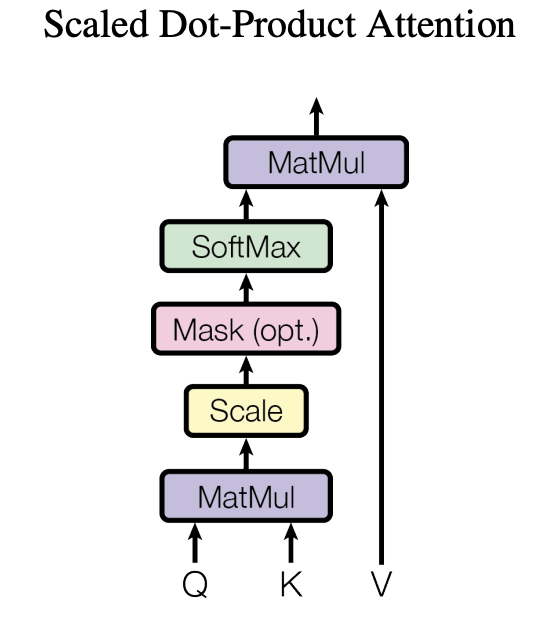)

In [8]:
# Queries * Keys 
energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
print('energy: ', energy.shape)

# Get Attention Score
scaling = emb_size ** (1/2)
att = F.softmax(energy/scaling, dim=1)
print('att: ', att.shape)

# Attention Score * values
out = torch.einsum('bhal, bhlv -> bhav', att, values)  
print('out: ', out.shape)

# Reagrrange to emb_size
out_1 = rearrange(out, "b h n d -> b n (h d)") # 처음 input(x)과 같은 shape으로 반환 
print('out_1: ', out_1.shape)

energy:  torch.Size([8, 8, 197, 197])
att:  torch.Size([8, 8, 197, 197])
out:  torch.Size([8, 8, 197, 96])
out_1:  torch.Size([8, 197, 768])


#### einsum 짚고 넘어가기
einsum 연산을 통해 행렬, 벡터의 내적(Dot products), 외적(Outer products), 전치(Transpose), 행렬곱 등을 일관성있게 표현 가능하게 하는 것
</br> 

![einsum](./einsum_example.png)

In [13]:
# Class로 묶어주기
class MutiHeadAttention(nn.Module):
    def __init__(self, emb_size: int=768, num_heads: int=8, dropout: float=0) -> None:
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads

        self.qkv = nn.Linear(emb_size, emb_size*3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x:Tensor, mask:Tensor=None):
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]

        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min # torch.finfo가 뭐지? 찾아보기!
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy / scaling, dim=1)
        att = self.att_drop(att)

        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)

        return out

x = torch.randn(8, 3, 224, 224)
patch_emb = PatchEmbedding()
x = patch_emb(x)
print(x.shape) # input과 같은 shape인지 확인

MHA = MutiHeadAttention()
summary(MHA, x.shape[1:], device='cpu') 

torch.Size([8, 197, 768])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1            [-1, 197, 2304]       1,771,776
           Dropout-2          [-1, 8, 197, 197]               0
            Linear-3             [-1, 197, 768]         590,592
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.58
Forward/backward pass size (MB): 6.99
Params size (MB): 9.01
Estimated Total Size (MB): 16.57
----------------------------------------------------------------


#### Transformer Encoder Block
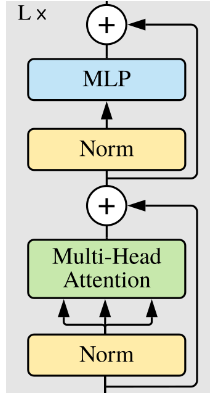

In [15]:
class ResidualAdd(nn.Module):
    def __init__(self, fn) -> None:
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

# MLP
class FeedFowardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int=4, drop_p: float=0.):
        super().__init__(
            nn.Linear(emb_size, expansion*emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion*emb_size, emb_size)
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int=768, 
                 drop_p: float=0.,
                 forward_expansion: int=4,
                 forward_drop_p: float=0.,
                 **kwargs):
        
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MutiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedFowardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

x = torch.randn(8, 3, 224, 224)
x = patch_emb(x)
x = MHA(x)
TE = TransformerEncoderBlock()
summary(TE, x.shape[1:], device='cpu')

    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 197, 768]           1,536
            Linear-2            [-1, 197, 2304]       1,771,776
           Dropout-3          [-1, 8, 197, 197]               0
            Linear-4             [-1, 197, 768]         590,592
 MutiHeadAttention-5             [-1, 197, 768]               0
           Dropout-6             [-1, 197, 768]               0
       ResidualAdd-7             [-1, 197, 768]               0
         LayerNorm-8             [-1, 197, 768]           1,536
            Linear-9            [-1, 197, 3072]       2,362,368
             GELU-10            [-1, 197, 3072]               0
          Dropout-11            [-1, 197, 3072]               0
           Linear-12             [-1, 197, 768]       2,360,064
          Dropout-13             [-1, 197, 768]               0
      ResidualAdd-14             [-1, 1

#### 모두 묶어서 ViT 빌드

In [17]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int=12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

# 
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int=768, n_classes: int=1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

class ViT(nn.Sequential):
    def __init__(self, 
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

summary(ViT(), (3, 224, 224), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
 MutiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19